## Practice

Task in a single paragraph:

This Python function analyzes a list of stock tickers by downloading their historical data, calculating daily returns, and downloading Fama-French benchmark factors. It computes various performance metrics including cumulative returns, Sharpe Ratios, and market betas for each stock in the 2020s, as well as for an equally weighted portfolio of those stocks. The function then visualizes the cumulative returns and market betas over time, and calculates Sharpe Ratios and betas using both the .pipe() method and direct calculations. The output includes cumulative returns, Sharpe Ratios, and betas for each stock and portfolio, along with plots of these metrics.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf
import pandas_datareader as pdr
import requests_cache

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format
session = requests_cache.CachedSession(expire_after=1)

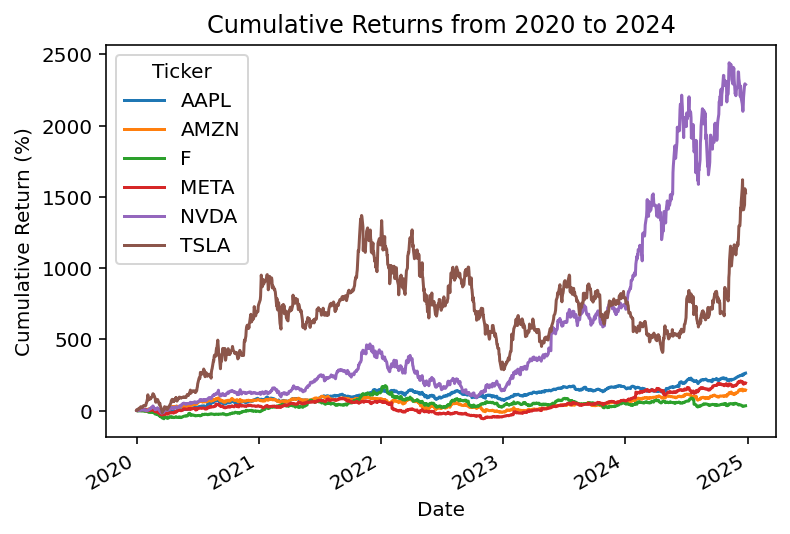

Sharpe Ratio for AAPL: 0.83
Sharpe Ratio for AMZN: 0.52
Sharpe Ratio for F: 0.32
Sharpe Ratio for META: 0.65
Sharpe Ratio for NVDA: 1.42
Sharpe Ratio for TSLA: 0.98
Beta for AAPL: 1.14
Beta for AMZN: 1.07
Beta for F: 1.22
Beta for META: 1.29
Beta for NVDA: 1.74
Beta for TSLA: 1.61
Portfolio Sharpe Ratio: 1.12
Portfolio Beta: 1.35


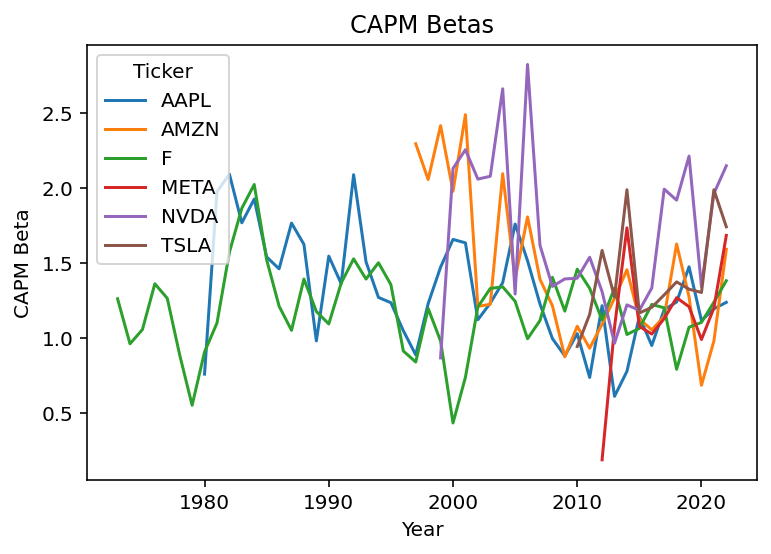

In [3]:
def analyze_stocks(tickers, session=None):
    # Step 1: Download stock data
    tickers = yf.Tickers(tickers, session=session)
    histories = tickers.history(period='max', auto_adjust=False, progress=False)
    histories.columns.names = ['Variable', 'Ticker']
    histories.index = histories.index.tz_localize(None)

    # Step 2: Calculate daily returns
    returns = histories['Adj Close'].pct_change()

    # Step 3: Slice returns for 2020s
    returns_2020s = returns.loc['2020':]

    # Step 4: Download Fama-French data
    ff_all = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start='1900', session=session)
    ff = ff_all[0] / 100

    # Step 5: Calculate cumulative returns
    cumprod_solution = returns_2020s.add(1).cumprod().sub(1).mul(100)
    cumsum_solution = returns_2020s.add(1).pipe(np.log).cumsum().pipe(np.exp).sub(1).mul(100)
    
    # Plot cumulative returns
    cumprod_solution.plot()
    plt.ylabel('Cumulative Return (%)')
    plt.title(f'Cumulative Returns from {cumprod_solution.index[0]:%Y} to {cumprod_solution.index[-1]:%Y}')
    plt.show()

    # Step 6: Sharpe Ratio function
    def sharpe(ri, rf=ff['RF']):
        ri_rf = ri.sub(rf).dropna()
        return np.sqrt(252) * ri_rf.mean() / ri_rf.std()

    # Calculate Sharpe Ratio for each stock in the 2020s
    for ticker in returns_2020s:
        sharpe_i = sharpe(returns_2020s[ticker])
        print(f'Sharpe Ratio for {ticker}: {sharpe_i:.2f}')

    # Step 7: Beta function
    def beta(ri, rf=ff['RF'], rm_rf=ff['Mkt-RF']):
        ri_rf = ri.sub(rf).dropna()
        rm_rf = rm_rf.loc[ri_rf.index]
        return ri_rf.cov(rm_rf) / rm_rf.var()

    # Calculate Beta for each stock in the 2020s
    for ticker in returns_2020s:
        beta_i = beta(returns_2020s[ticker])
        print(f'Beta for {ticker}: {beta_i:.2f}')

    # Step 8: Portfolio calculations
    returns_2020s_excess = returns_2020s.sub(ff['RF'], axis=0).dropna()
    returns_2020s_excess['Mkt-RF'] = ff['Mkt-RF']

    # Portfolio Sharpe Ratio
    portfolio_sharpe = returns_2020s.mean(axis=1).pipe(sharpe)
    print(f'Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}')

    # Portfolio Beta
    portfolio_beta = returns_2020s.mean(axis=1).pipe(beta)
    print(f'Portfolio Beta: {portfolio_beta:.2f}')

    # Step 9: Plot market betas for each stock
    betas = []
    years = list(range(1973, 2023))
    for year in years:
        betas.append(returns.loc[str(year)].apply(beta))
    betas = pd.DataFrame(betas, index=years)
    betas.columns.name = 'Ticker'
    betas.index.name = 'Year'
    betas.plot()
    plt.ylabel('CAPM Beta')
    plt.title('CAPM Betas')
    plt.show()

    return {
        'cumulative_returns': cumprod_solution,
        'sharpe_ratios': {ticker: sharpe(returns_2020s[ticker]) for ticker in returns_2020s},
        'betas': {ticker: beta(returns_2020s[ticker]) for ticker in returns_2020s}
    }

# Example usage
result = analyze_stocks('TSLA F AAPL AMZN META NVDA')
